In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shapely
import shapely.geometry
import shapely.plotting
import shapely.ops
import cv2
%matplotlib widget

In [283]:
im = plt.imread('ExampleMap.png')
#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

img = cv2.imread("mazetraining1.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 125, 255, 0)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)



In [284]:
def make_a_square(coords, size):
    a = coords[0]
    b = coords[1]
    return [(0 + a, 0 + b), (0 + a, size + b), (size + a, size + b), (size + a, 0 + b)]

In [285]:
inners = []
for contour in contours:
    current_shape = []
    for coord in contour:
        current_shape.append(tuple(coord[0]))
    #print(current_shape)
    inners.append(current_shape)
trimmed_inners = [x for x in inners if len(x) >= 4]
    
outers = make_a_square([0,0], 1000)
print(inners)
print(len(inners))
map_area = shapely.Polygon(outers, trimmed_inners[1:]).simplify(0.5, preserve_topology=False)

#map_area = shapely.reverse(map_area)

bounding_box = shapely.Polygon(make_a_square([-10,-10], 1020))
inverted_polygon = bounding_box.symmetric_difference(map_area)
map_area = inverted_polygon


[[(0, 0), (0, 1299), (1299, 1299), (1299, 0)], [(597, 1173), (598, 1172), (599, 1172), (600, 1173), (600, 1174), (601, 1175), (601, 1176), (603, 1178), (603, 1179), (604, 1180), (604, 1181), (605, 1182), (605, 1183), (607, 1185), (607, 1186), (608, 1187), (608, 1188), (609, 1189), (609, 1190), (611, 1192), (611, 1193), (612, 1194), (612, 1195), (613, 1196), (613, 1197), (615, 1199), (615, 1200), (616, 1201), (616, 1203), (615, 1204), (601, 1204), (601, 1275), (600, 1276), (597, 1276), (595, 1274), (595, 1204), (581, 1204), (580, 1203), (580, 1202), (582, 1200), (582, 1199), (583, 1198), (583, 1197), (584, 1196), (584, 1195), (585, 1194), (585, 1193), (586, 1192), (586, 1191), (588, 1189), (588, 1188), (590, 1186), (590, 1185), (591, 1184), (591, 1183), (592, 1182), (592, 1181), (594, 1179), (594, 1178), (595, 1177), (595, 1176), (597, 1174)], [(340, 711), (341, 710), (342, 710), (343, 711), (423, 711), (424, 712), (424, 719), (423, 720), (348, 720), (340, 712)], [(160, 557), (167, 557)

current_shapes = []
for contour in contours:
    current_shape = []
    for coord in contour:
        current_shape.append(tuple(coord[0]))
    print(current_shape)
    current_shapes.append(current_shape)

for i in range(1,len(current_shapes)):
    shapely.plotting.plot_polygon(shapely.geometry.Polygon(current_shapes[i]), ax=ax, facecolor='lightblue', edgecolor='red')
    

In [286]:
def equidistant_circle_points(n,r):
    n = 20
    r = 60
    circles = []
   
    for i in range(n):
        t = np.linspace(0, 2*np.pi, n, endpoint=False)
        x = r * np.cos(t)
        y = r * np.sin(t)
        
        circles.append(np.c_[x, y])
    return circles
    

In [287]:
class Enviroment():
    def __init__(self, map_area):
        self.map_area = map_area
    def refresh(self, robot):
        plt.clf()
        shapely.plotting.plot_polygon(map_area)
        for n in range(len(robot.sensor_vectors)):
            if robot.sensor_readings[n] < 100:
                shapely.plotting.plot_line(robot.sensor_vectors[n], color="r")
            else:
                shapely.plotting.plot_line(robot.sensor_vectors[n], color="green")
        shapely.plotting.plot_line(shapely.LineString(robot.path),color="r")

In [288]:


class Robot(Enviroment):
    def __init__(self, enviroment, start_position, sensor_num, sensor_range, path = []):
        
        fig = plt.figure(figsize = (6,6))
        ax = fig.add_subplot(111)
        ax.set_box_aspect(1)
        ax.grid()
        plt.gca().set_aspect('equal')
        
        self.ax = ax
        self.pose = start_position
        self.enviroment = enviroment
        self.path = [tuple(self.pose), tuple(self.pose)]
        self.sensor_range = sensor_range
        self.sensor_offsets = np.array(equidistant_circle_points(sensor_num, sensor_range))
        self.sensor_vectors = []
        self.sensor_readings = np.ones(sensor_num) + 99
        self.update_sensors()
        
    def move(self, pose_change):
        self.pose += pose_change
        self.path.append(tuple(self.pose))
        self.update_sensors()
        
    def update_sensors(self):
        real_pose = self.sensor_offsets + self.pose
        temp_sensors = []
        for sensor in real_pose[0]:
            temp_sensor = shapely.LineString([tuple(self.pose), tuple(sensor)])
            temp_sensors.append(temp_sensor)
            
        self.sensor_vectors = temp_sensors
        for i in range(len(self.sensor_vectors)):
            intersection = shapely.get_point(shapely.intersection(self.sensor_vectors[i], self.enviroment.map_area), 0)
            if intersection != None:
                intersection_distance = np.linalg.norm(np.array([intersection.x, intersection.y]) - self.pose)
                self.sensor_readings[i] = intersection_distance
            else:
                self.sensor_readings[i] = 100
        self.enviroment.refresh(self)
        
    def get_closest_sensor_readings(self, point_of_interest):
        angle = (2 * np.pi) / len(self.sensor_readings)
        distances = []
        angle_step = 1
        closest_readings = []
        for i in self.sensor_readings:
            angle_step += 1
            reading_pose = np.array(i * np.cos(angle * angle_step), i * np.sin(angle * angle_step))
            #print(reading_pose)
            #print(reading_pose, angle_step)
            distances.append(np.linalg.norm(point_of_interest - reading_pose))
        for n in range(4):
            print([i for i in sorted(range(len(distances)), key=lambda k: distances[k])[:4]])
            closest_readings = [self.sensor_readings[i] for i in sorted(range(len(distances)), key=lambda k: distances[k])[:4]]
            #print(closest_readings)
            return(closest_readings)

[100.           3.23606798   1.70130162   1.23606798 100.
 100.         100.           1.23606798   1.70130162   3.23606798
 100.         100.         100.          49.4427191   42.05848897
  40.          42.05848897 100.         100.         100.        ]


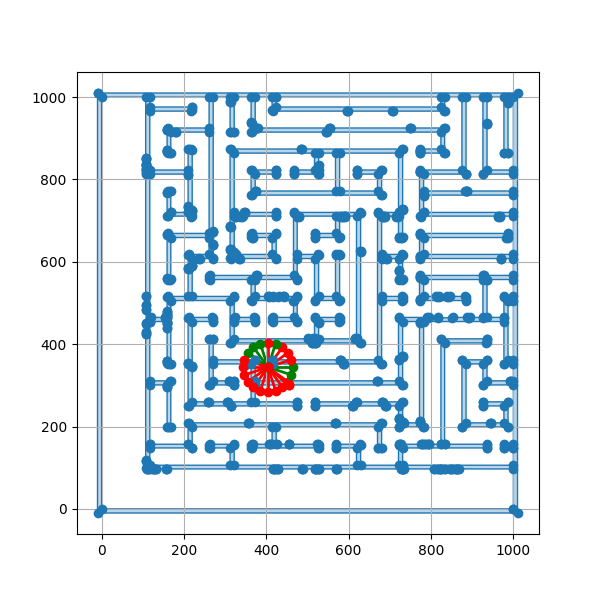

In [289]:
Map1 = Enviroment(map_area)
Scrimblo = Robot(Map1, np.array([454,300]), 20, 8)
print(Scrimblo.sensor_readings)
#Scrimblo.move(np.array([44,44]))
Scrimblo.move(np.array([-50,44]))


#print(Scrimblo.sensor_real_pose[0][1])
#ax.scatter(Scrimblo.sensor_real_pose[0,:,0], Scrimblo.sensor_real_pose[0,:,1])
#print(Scrimblo.sensor_real_pose[0,:,0], Scrimblo.sensor_real_pose[0,:,1])
#test_line = shapely.LineString([(3,4),(5,2)])
#print(test_line)
#test_line = shapely.LineString([(3,4),(5,2)])

# For neural network, need:
- Distance
- Polar Coordinate Angle
- Four sensor readings closest to <x,y>

# Binary Classification

In [290]:
#occupancy = np.full((100,100), 0.5) # Represents occupancy of individual grid cells on the map.


In [291]:
import random

def polar_coords(pose_1, pose_2):
    d = np.linalg.norm(pose_2 - pose_1)
    if pose_1[0] - pose_2[0] == 0:
        return d, 0
    theta = np.arctan((pose_1[1] - pose_2[1]) / (pose_1[0] - pose_2[0]))
    return d, theta

def training_point(robot, cell_num):
    POI = (random.randint(-cell_num,cell_num), random.randint(-cell_num,cell_num))
    POI_Pose = np.array(POI)
    occupied = int(shapely.within(shapely.Point(tuple(POI_Pose)), robot.enviroment.map_area))
    closest_readings = Robot.get_closest_sensor_readings(robot, POI_Pose)
    d, theta = polar_coords(robot.pose, POI_Pose)
    if any(v == 0 for v in closest_readings):
        return False
    else:
        return closest_readings + [d, theta, occupied]
#training_point(Robot(Map1, np.array([0,0]), 20, 60), 60, 13)
#print(polar_coords(np.array([14,20]), np.array([-120,230])))

[1, 0, 18, 19]
[15, 14, 16, 17]
[2, 3, 4, 5]
[17, 16, 15, 1]


[14, 1, 0, 19]
[6, 10, 11, 7]
[5, 6, 4, 7]
[11, 8, 7, 9]
[19, 0, 17, 18]
[7, 3, 13, 2]
[8, 9, 7, 10]
[19, 0, 18, 1]
[9, 8, 4, 12]
[11, 10, 12, 7]
[18, 17, 1, 16]
[1, 15, 0, 16]
[8, 6, 9, 4]
[5, 8, 7, 6]
[4, 5, 0, 1]
[5, 4, 6, 8]
[3, 13, 14, 12]
[3, 13, 12, 11]
[18, 17, 0, 1]
[12, 4, 13, 3]
[9, 8, 13, 2]
[15, 14, 16, 17]
[7, 4, 8, 5]
[1, 16, 15, 14]
[9, 10, 8, 7]
[5, 4, 6, 7]
[0, 1, 2, 3]
[3, 13, 17, 12]
[8, 9, 7, 10]
[8, 9, 7, 10]
[14, 1, 15, 0]
[15, 16, 1, 14]
[9, 8, 10, 11]
[5, 8, 6, 9]
[6, 5, 7, 8]
[19, 0, 18, 1]
[2, 14, 1, 3]
[17, 16, 18, 1]
[17, 19, 0, 18]
[8, 7, 11, 6]
[15, 2, 14, 19]
[2, 3, 4, 5]
[17, 14, 18, 16]
[0, 15, 16, 14]
[0, 1, 3, 4]
[15, 14, 16, 17]
[14, 0, 1, 2]
[11, 0, 1, 2]
[9, 8, 11, 7]
[15, 1, 2, 16]
[7, 6, 5, 4]
[10, 9, 8, 7]
[15, 16, 2, 14]
[3, 13, 14, 15]
[5, 4, 6, 7]
[3, 13, 4, 2]
[0, 19, 18, 17]
[12, 4, 3, 13]
[17, 19, 0, 16]
[5, 4, 6, 13]
[3, 13, 17, 18]
[2, 3, 4, 5]
[8, 7, 10, 6]
[17, 19, 16, 0]
[5, 4, 6, 10]
[1, 16, 17, 0]
[14, 3, 13, 4]
[6, 5, 7, 8]
[10, 1

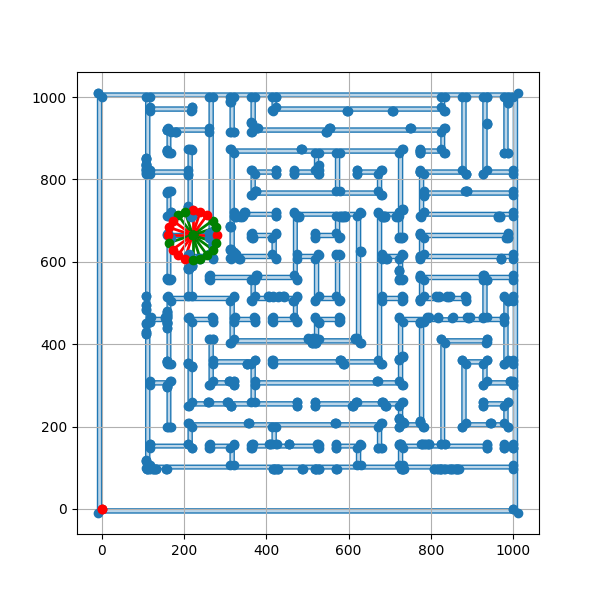

In [292]:
def create_training_data(num_of_sims):
    training_bot = Robot(Map1, np.array([0,0]), 20, 60)
    #
    training_data = []
    for sim in range(num_of_sims):
        training_bot.pose = np.array([random.randint(100,1000),random.randint(100,1000)])
        training_bot.update_sensors()
        training_point_temp = training_point(training_bot, 150)
        if training_point_temp != False:  
            training_data.append(training_point_temp)
    return(training_data)

training_data = create_training_data(100)


In [293]:
import pandas as pd
training_data_dataframe = pd.DataFrame(training_data)
Y = training_data_dataframe[6]
X = training_data_dataframe.drop(6, axis=1)

In [294]:
print(training_data)

[[100.0, 100.0, 39.12993718419384, 100.0, 1055.1781840049575, 0.7445088272865464, 0], [100.0, 100.0, 100.0, 8.50650808352043, 776.2325682422762, 1.1515255620188163, 0], [43.26237921249263, 36.801177848339336, 35.0, 100.0, 671.1460347793169, 0.41565247443275966, 0], [48.541019662496815, 27.33801783019495, 26.0, 27.33801783019495, 771.4927089739734, 0.7753160119019225, 0], [100.0, 100.0, 100.0, 100.0, 1420.4143761592952, 0.8466680126220915, 0], [100.0, 100.0, 100.0, 100.0, 1081.0296018148624, 0.650901528734289, 0], [100.0, 29.665631459994948, 29.665631459994948, 25.23509338171841, 601.0158067804873, 0.6887732851637297, 0], [58.88188455734297, 56.0, 100.0, 100.0, 633.0655574267171, 0.232718741010681, 0], [3.7082039324993725, 3.7082039324993725, 48.206651122491806, 5.103904850112221, 582.0532621676473, 0.06016825115500972, 0], [100.0, 100.0, 100.0, 100.0, 1006.0864773964513, 1.0426503322571903, 0], [100.0, 32.0, 25.519524250561197, 33.64679117562455, 178.36199146679206, 0.12365958436678817

In [295]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import sklearn
     

In [296]:
X = np.array(X)
print(X)
Y = np.array(Y)
print(X.shape)
model = Sequential()
model.add(Dense(1, input_shape=(X.shape[1],), activation='sigmoid')) # Add an input shape! (features,)
model.add(Dense(48, activation='relu'))
#model.add(Dense(units = 6 , activation = 'sigmoid', input_shape=(X.shape[1],))) 
# Second layer: 1 neuron/perceptron that takes the input from the 1st layers and gives output as 0 or 1.Activation used is 'Hard Sigmoid'
model.add(Dense(1, activation = 'sigmoid'))

# compiling the model
sgd = keras.optimizers.SGD(learning_rate=0.5, momentum=0.9, nesterov=True)
model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
     

model.summary() 

# compile the model
model.compile(optimizer='sgd', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  

# now we just update our model fit call

# training the model

# training the model

# Split data into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# Check the dimension of the sets
print('X_train:',np.shape(X_train))
print('y_train:',np.shape(y_train))
print('X_test:',np.shape(X_test))
print('y_test:',np.shape(y_test))



[[ 1.00000000e+02  1.00000000e+02  3.91299372e+01  1.00000000e+02
   1.05517818e+03  7.44508827e-01]
 [ 1.00000000e+02  1.00000000e+02  1.00000000e+02  8.50650808e+00
   7.76232568e+02  1.15152556e+00]
 [ 4.32623792e+01  3.68011778e+01  3.50000000e+01  1.00000000e+02
   6.71146035e+02  4.15652474e-01]
 [ 4.85410197e+01  2.73380178e+01  2.60000000e+01  2.73380178e+01
   7.71492709e+02  7.75316012e-01]
 [ 1.00000000e+02  1.00000000e+02  1.00000000e+02  1.00000000e+02
   1.42041438e+03  8.46668013e-01]
 [ 1.00000000e+02  1.00000000e+02  1.00000000e+02  1.00000000e+02
   1.08102960e+03  6.50901529e-01]
 [ 1.00000000e+02  2.96656315e+01  2.96656315e+01  2.52350934e+01
   6.01015807e+02  6.88773285e-01]
 [ 5.88818846e+01  5.60000000e+01  1.00000000e+02  1.00000000e+02
   6.33065557e+02  2.32718741e-01]
 [ 3.70820393e+00  3.70820393e+00  4.82066511e+01  5.10390485e+00
   5.82053262e+02  6.01682512e-02]
 [ 1.00000000e+02  1.00000000e+02  1.00000000e+02  1.00000000e+02
   1.00608648e+03  1.0426

In [297]:
# FIND THE BEST MODEL!!
# https://www.learndatasci.com/glossary/binary-classification/

In [298]:
# training the model
model.fit(X_train, y_train, epochs=50)
     

Epoch 1/50
3/3 [==============================] - 1s 3ms/step - loss: 0.6919 - accuracy: 0.9697
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.9697
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.6746 - accuracy: 0.9697
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.6655 - accuracy: 0.9697
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.6567 - accuracy: 0.9697
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.6480 - accuracy: 0.9697
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.6395 - accuracy: 0.9697
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.6312 - accuracy: 0.9697
Epoch 9/50
3/3 [==============================] - 0s 2ms/step - loss: 0.6231 - accuracy: 0.9697
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 0.6152 - accuracy: 0.9697
Epoch 11/50
3/3 [======================

In [299]:
# Test, Loss and accuracy
loss_and_metrics = model.evaluate(X_test, y_test)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])
     

1/1 [==============================] - 0s 125ms/step - loss: 0.3708 - accuracy: 1.0000
Loss =  0.37075766921043396
Accuracy =  1.0


[10, 6, 11, 5]
1/1 [==============================] - 0s 49ms/step
[10, 6, 11, 5]
1/1 [==============================] - 0s 17ms/step
[6, 10, 11, 5]
1/1 [==============================] - 0s 15ms/step
[6, 10, 11, 5]
1/1 [==============================] - 0s 20ms/step
[5, 11, 6, 10]
1/1 [==============================] - 0s 15ms/step
[5, 11, 12, 4]
1/1 [==============================] - 0s 14ms/step
[12, 4, 5, 11]
1/1 [==============================] - 0s 15ms/step
[4, 12, 9, 8]
1/1 [==============================] - 0s 14ms/step
[9, 4, 12, 8]
1/1 [==============================] - 0s 16ms/step
[8, 7, 9, 3]
1/1 [==============================] - 0s 17ms/step
[10, 6, 11, 5]
1/1 [==============================] - 0s 15ms/step
[6, 10, 11, 5]
1/1 [==============================] - 0s 14ms/step
[6, 10, 11, 5]
1/1 [==============================] - 0s 16ms/step
[11, 5, 6, 10]
1/1 [==============================] - 0s 15ms/step
[5, 11, 12, 4]
1/1 [==============================] - 0s 15ms/step

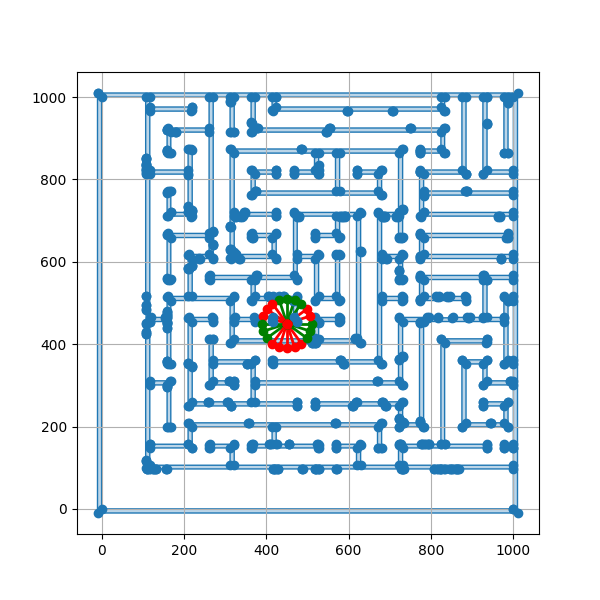

In [300]:
block_amount = 5
occupancy = np.full((block_amount,block_amount), 0.5) # Represents occupancy of individual grid cells on the map.
map_size = 100 # 1000 by 1000, thus the blocks are 10 units in size.
block_size = map_size / block_amount
test_robot = Robot(Map1, np.array([450,450]), 20, 60)

non_zero = 0

for i in range(-block_amount, block_amount):
    for j in range (-block_amount, block_amount):
        reading_to_test = np.array([i * block_size, j * block_size])
        #print(reading_to_test)
        closest_readings = Robot.get_closest_sensor_readings(test_robot, reading_to_test)
        #print(closest_readings)
        #print([test_robot.pose[0] + i * block_size, test_robot.pose[0] + j * block_size])
        d, theta = polar_coords(np.array([0,0]), np.array([i * block_size, j * block_size]))
        to_predict = np.array([closest_readings + [d, theta]])
        #print(to_predict)
        #print(to_predict)
        #print(to_predict.shape)
        prediction = model.predict(to_predict)
        #print(prediction)
        occupancy[i,j] = prediction

In [301]:
print(occupancy)

[[0.30981144 0.39623702 0.30978876 0.30978879 0.30978879]
 [0.39623702 0.30978668 0.30978879 0.30978879 0.30978879]
 [0.30978876 0.30978879 0.30978879 0.30978879 0.30978879]
 [0.30978879 0.30978879 0.30978879 0.30978876 0.30978879]
 [0.30978879 0.30978879 0.30978879 0.30978879 0.30978879]]
